In [1]:
pip install pandas numpy praw yfinance nltk scikit-learn tensorflow matplotlib



  Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl.metadata (3.3 kB)
     ---------------------------------------- 0.0/948.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/948.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/948.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/948.2 kB ? eta -:--:--
     ----------- ---------------------------- 262.1/948.2 kB ? eta -:--:--
     ----------- ---------------------------- 262.1/948.2 kB ? eta -:--:--
     ----------- ---------------------------- 262.1/948.2 kB ? eta -:--:--
     ----------- ---------------------------- 262.1/948.2 kB ? eta -:--:--
     ------------------- ---------------- 524.3/948.2 kB 294.2 kB/s eta 0:00:02
     ------------------- ---------------- 524.3/948.2 kB 294.2 kB/s eta 0:00:02
     ------------------- ---------------- 524.3/948.2 kB 294.2 kB/s eta 0:00:02
     ----------------------------- ------ 786.4/948.2 kB 381.3 kB/s eta 0:00:01
     -----

Enter the stock ticker (e.g., TSLA, AAPL):  TSLA


[*********************100%***********************]  1 of 1 completed


Training Random Forest...
Random Forest Metrics: RMSE=8.606715788471826, MAE=5.795688285574233, R²=0.9879190529099823, EVS=0.988062027583295, MAPE=0.026875262320409602, MSLE=0.0014643175320523765


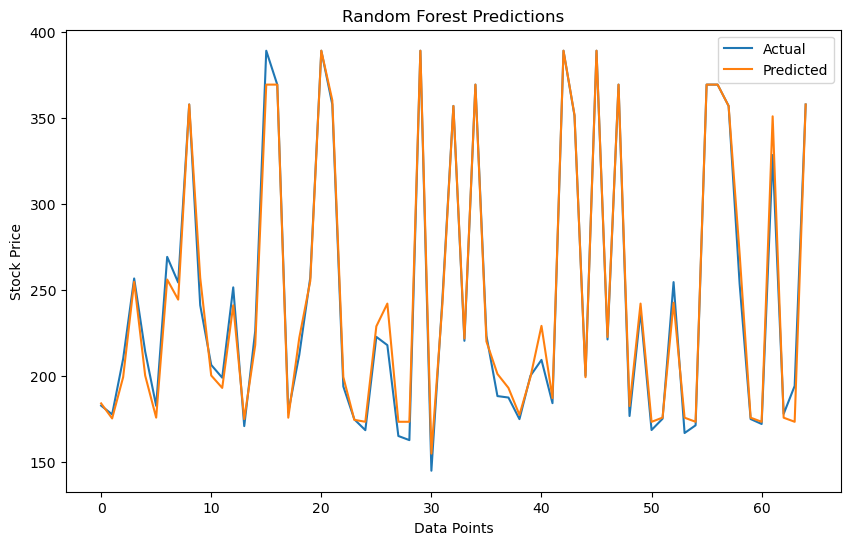

Training LSTM...
Epoch 1/10


C:\Users\Deepa Kotapati\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0761
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0214
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0130
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0118
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0104
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0077
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0070
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0069
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0072
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0059
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 360ms/step
LSTM Metrics: RMSE=5.408043409283512, MAE=4.609281144052182, R²=0.791420185116825, EVS=0.8189167139158453, MAPE=0.012265227667776128, MSLE=0.00020308727395640575


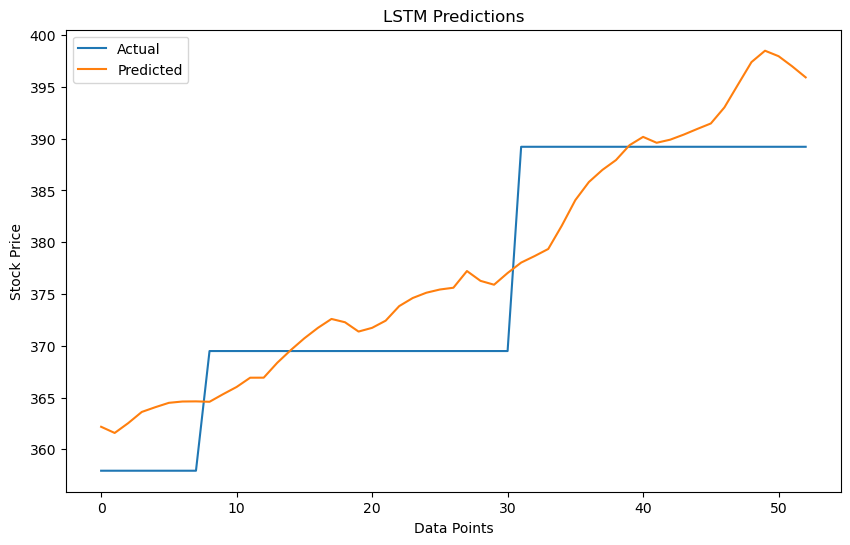

In [13]:
import praw
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, mean_absolute_percentage_error, mean_squared_log_error
import yfinance as yf
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import nltk


# Initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Step 1: Scrape real-time data from Reddit using the API
def fetch_reddit_data(client_id, client_secret, user_agent, subreddit="stocks", limit=100):
    reddit = praw.Reddit(client_id=client_id, client_secret=client_secret, user_agent=user_agent)
    subreddit = reddit.subreddit(subreddit)
    posts = []
    for post in subreddit.hot(limit=limit):  # Fetch top posts
        posts.append({"title": post.title, "date": datetime.fromtimestamp(post.created_utc).strftime('%Y-%m-%d')})
    df_reddit = pd.DataFrame(posts)
    df_reddit['date'] = pd.to_datetime(df_reddit['date'])
    return df_reddit

# Step 2: Sentiment Analysis on Reddit data
def analyze_sentiment(df_reddit):
    df_reddit['sentiment'] = df_reddit['title'].apply(lambda x: sia.polarity_scores(x)['compound'])
    return df_reddit

# Step 3: Fetch historical stock data
def fetch_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    stock_data.reset_index(inplace=True)
    stock_data['date'] = pd.to_datetime(stock_data['Date'])
    return stock_data[['date', 'Close']]

# Step 4: Merge sentiment data with stock data
def merge_data(df_reddit, stock_data):
    # Flatten MultiIndex in stock_data
    if isinstance(stock_data.columns, pd.MultiIndex):
        stock_data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in stock_data.columns]

    # Rename columns for consistency
    stock_data.rename(columns={"date_": "date", f"Close_{ticker}": "Close"}, inplace=True)

    # Ensure the 'date' column is of datetime type
    stock_data['date'] = pd.to_datetime(stock_data['date'])
    df_reddit['date'] = pd.to_datetime(df_reddit['date'])

    # Merge data
    merged_data = pd.merge(stock_data[['date', 'Close']], df_reddit[['date', 'sentiment']], on='date', how='left')
    merged_data['sentiment'] = merged_data['sentiment'].fillna(0)
    return merged_data


# Updated Random Forest Model with Advanced Metrics
def train_rf_with_tuning(data):
    data['prev_close'] = data['Close'].shift(1)
    data.dropna(inplace=True)
    X = data[['prev_close', 'sentiment']]
    y = data['Close']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Hyperparameter tuning with GridSearchCV
    param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, None]}
    grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Predictions and evaluation
    predictions = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    evs = explained_variance_score(y_test, predictions)
    mape = mean_absolute_percentage_error(y_test, predictions)
    msle = mean_squared_log_error(y_test, predictions)

    print(f"Random Forest Metrics: RMSE={rmse}, MAE={mae}, R²={r2}, EVS={evs}, MAPE={mape}, MSLE={msle}")
    return best_model, X_test, y_test, predictions


# Updated LSTM Model with Advanced Metrics
def train_lstm(data):
    data['prev_close'] = data['Close'].shift(1)
    data.dropna(inplace=True)
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Preparing the dataset
    scaled_data = scaler.fit_transform(data[['prev_close', 'sentiment', 'Close']])
    X = []
    y = []
    for i in range(60, len(scaled_data)):
        X.append(scaled_data[i-60:i, :2])
        y.append(scaled_data[i, 2])

    X, y = np.array(X), np.array(y)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Build LSTM Model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1)

    # Predictions and evaluation
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(np.hstack((np.zeros_like(predictions), np.zeros_like(predictions), predictions.reshape(-1, 1))))[:, 2]
    y_test = scaler.inverse_transform(np.hstack((np.zeros_like(y_test.reshape(-1, 1)), np.zeros_like(y_test.reshape(-1, 1)), y_test.reshape(-1, 1))))[:, 2]

    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    evs = explained_variance_score(y_test, predictions)
    mape = mean_absolute_percentage_error(y_test, predictions)
    msle = mean_squared_log_error(y_test, predictions)

    print(f"LSTM Metrics: RMSE={rmse}, MAE={mae}, R²={r2}, EVS={evs}, MAPE={mape}, MSLE={msle}")
    return model, X_test, y_test, predictions


# Visualization Function
def visualize_results(y_test, predictions, title="Actual vs Predicted Stock Prices"):
    results = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
    results.reset_index(drop=True, inplace=True)
    results.plot(title=title, figsize=(10, 6))
    plt.xlabel("Data Points")
    plt.ylabel("Stock Price")
    plt.show()

# Main Execution
if __name__ == "__main__":
    CLIENT_ID = "nnRGnFbPr9d-r-u_Rioq3Q"
    CLIENT_SECRET = "NYKFsBoSBWPf0FMfxal4Etg2LHj11g"
    USER_AGENT = "StockSentimentAnalysisApp/1.0"

    ticker = input("Enter the stock ticker (e.g., TSLA, AAPL): ")
    start_date = (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d')
    end_date = datetime.now().strftime('%Y-%m-%d')

    # Fetch Reddit and stock data
    df_reddit = fetch_reddit_data(CLIENT_ID, CLIENT_SECRET, USER_AGENT)
    df_reddit = analyze_sentiment(df_reddit)
    stock_data = fetch_stock_data(ticker, start_date, end_date)
    merged_data = merge_data(df_reddit, stock_data)

    # Train Random Forest and LSTM models
    print("Training Random Forest...")
    rf_model, X_test_rf, y_test_rf, rf_predictions = train_rf_with_tuning(merged_data)
    visualize_results(y_test_rf, rf_predictions, title="Random Forest Predictions")

    print("Training LSTM...")
    lstm_model, X_test_lstm, y_test_lstm, lstm_predictions = train_lstm(merged_data)
    visualize_results(y_test_lstm, lstm_predictions, title="LSTM Predictions")
